In [1]:
import numpy as np
from scipy import ndimage
from scipy.ndimage import convolve
from scipy.ndimage import gaussian_filter,sobel
from scipy import misc
from PIL import Image


In [2]:
import cv2
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg

Ở đây tôi thêm 1 lớp filter gaussian cho ảnh để làm nhiễu ảnh :)) mục đích là làm ảnh mịn hơn

![alt text](../Gau.png)

In [3]:
# Khử nhiễu cho ảnh
# Code lại công thức cho mình!!!
def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g

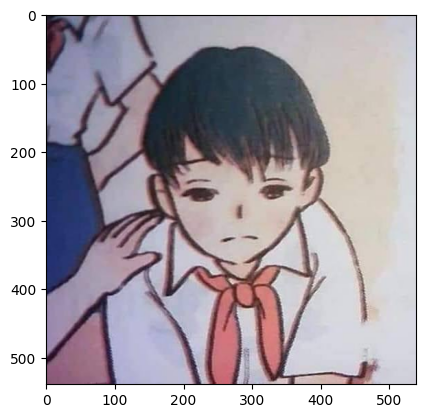

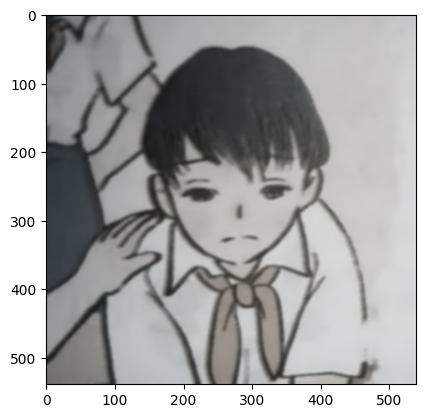

In [4]:
#Ví dụ
imgs = Image.open(r"D:\\project_CTV\\avatar.jpg")
plt.imshow(imgs)
plt.show()
data_img = np.array(imgs)
data_img1 = gaussian_filter(data_img,sigma=1)
data_img1 = gaussian_filter(data_img1,sigma=1)
data_img1 = gaussian_filter(data_img1,sigma=1)
plt.imshow(data_img1)
plt.show()

Tính toán độ xám 

Bước tính toán Gradient độ xám phát hiện các cạnh thông qua cường độ và hướng của gradient độ xám.

Các cạnh tương ứng với sự thay đổi cường độ sáng của pixel. Để phát hiện nó, cách dễ nhất là áp dụng các Filter làm nổi bật sự thay đổi cường độ này theo cả hai hướng: ngang (x) và dọc (y)

Sau Khi hình ảnh được làm mịn, các đạo hàm Ix và Iy w.r.t. x và y được tính. Việc này có thể được thực hiện bằng cách nhân chập I với các Sobel kernel Kx và Ky, tương ứng:

![alt text](../sobel1.png)

Sobel Filter cho cả hai chiều ngang và dọc

Sau đó, độ lớn G và góc θ của gradient được tính như sau:

Với G là cường độ của Gradient và theta là góc(hướng) của cạnh


![alt text](../sobel2.png)

In [5]:
#Ở đây tôi dùng sobel filters nhé
import scipy


def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    Ix = ndimage.filters.convolve(img, Kx)
    Iy = ndimage.filters.convolve(img, Ky)
    
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    #G là ảnh được lưu dưới dạng ma trận sau khi nhân tích chập, còn theta là số đo góc của mỗi pixel
    return (G, theta)


In [6]:
import numpy as np
from scipy import ndimage

(640, 960, 3)


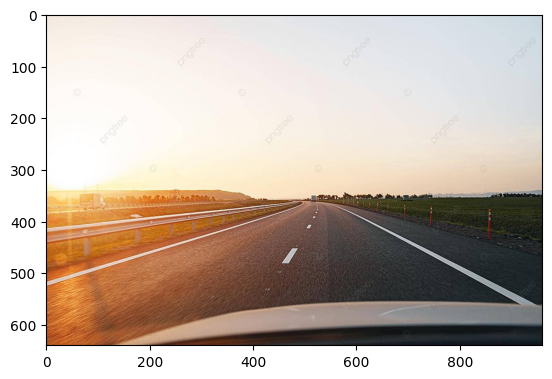

(640, 960)


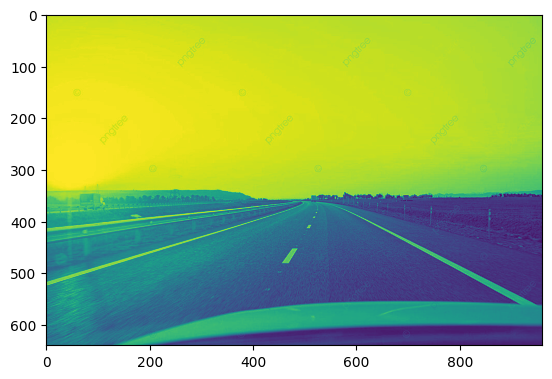

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_14528\2559970681.py:9: DeprecationWarning: Please import `convolve` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  Ix = ndimage.filters.convolve(img, Kx)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_14528\2559970681.py:10: DeprecationWarning: Please import `convolve` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  Iy = ndimage.filters.convolve(img, Ky)


(640, 960)


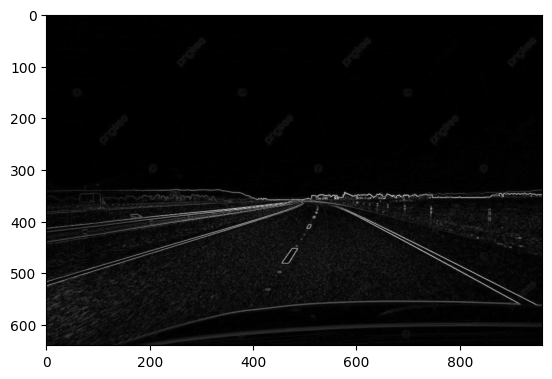

In [7]:
import scipy
from PIL import Image
import numpy as np
img = mpimg.imread(r"..\\road1.jpg")
print(img.shape)
plt.imshow(img)
plt.show()
img = img.mean(axis=2)
print(img.shape)
plt.imshow(img)
plt.show()
new_img, theta = sobel_filters(img)
print(new_img.shape)
plt.imshow(new_img, cmap='gray')
plt.show()


Sau bước này mà ảnh => 1 số cạnh dày và 1 số cạnh mỏng là thành công

Bước sau chúng ta sẽ làm mỏng lại các cạnh

Làm mỏng các cạnh 


Nguyên tắc rất đơn giản: thuật toán đi qua tất cả các điểm trên ma trận cường độ gradient và tìm các pixel có giá trị lớn nhất theo các hướng cạnh.

![alt text](../mong1.png)

Hộp màu đỏ ở góc trên bên trái đại diện cho một pixel cường độ của ma trận Cường độ Gradient đang được xử lý. Hướng gradient tương ứng được biểu diễn bằng mũi tên màu cam với góc -pi radian (+/- 180 độ).

![alt text](../mong2.png)

Hướng gradient là đường chấm màu cam (nằm ngang từ trái sang phải). Mục đích của thuật toán là để kiểm tra xem các pixel trên cùng một hướng có cường độ cao hơn hay thấp hơn các pixel đang được xử lý. Trong ví dụ trên, pixel (i, j) đang được xử lý và các pixel trên cùng một hướng được đánh dấu bằng màu xanh lam (i, j-1) và (i, j + 1).

Nếu một trong hai pixel đó có cường độ cao hơn pixel đang được xử lý, thì chỉ có một pixel có cường độ cao hơn được giữ lại. Pixel (i, j-1) có vẻ sáng hơn, vì nó có màu trắng (giá trị 255).

Do đó, giá trị cường độ của pixel hiện tại (i, j) được đặt thành 0. Nếu không có pixel nào ở hướng cạnh có giá trị cường độ cao hơn thì giá trị của pixel hiện tại được giữ nguyên. Bây giờ chúng ta hãy tập trung vào một ví dụ khác:

![alt text](../mong3.png)

Trong trường hợp này, hướng là đường chéo chấm màu cam. Do đó, pixel cường độ cao nhất theo hướng này là pixel (i-1, j + 1).

Tóm gọn lại, mỗi pixel được đánh giá bằng 2 tiêu chí chính (hướng cạnh tính bằng radian và cường độ pixel (từ 0–255). Dựa trên các đầu vào này, các bước non-maximum suppression là:

-Tạo một ma trận được khởi tạo bằng 0 có cùng kích thước của ma trận cường độ gradient ban đầu;

-Xác định hướng của gradient dựa trên giá trị góc từ ma trận góc;

-Kiểm tra xem pixel ở cùng một hướng có cường độ cao hơn pixel hiện đang được xử lý hay không;

-Trả lại hình ảnh được xử lý bằng thuật toán non-maximum suppression.

In [8]:
def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180
    for i in range(1,M-1):
        for j in range(1,N-1):
            # Trục x là các điểm i (trục dọc)
            # Trục y là các điểm j (trục ngang)
            # Tạo ma trận kề [i-1,j-1 | i-1,j | i-1,j+1]
            #                [ i ,j-1 |  i,j  |  i,j+1]
            #                [i+1,j-1 | i+1,j | i+1,j+1]
            # với (i,j) là trọng tâm
            try:
                q = 255
                r = 255                
                # Góc 0 độ: Di chuyển theo hướng ngang (x) hoặc chéo dọc (y)
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1] # Pixel bên phải
                    r = img[i, j-1] # Pixel bên trái
                # Góc 45 độ: Di chuyển từ trên phải xuống dưới trái
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i-1, j+1] # Pixel trên phải
                    r = img[i+1, j-1] # Pixel dưới trái
                # Góc 90 độ: Di chuyển theo hướng dọc (y)
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i-1, j] # Pixel trên
                    r = img[i+1, j] # Pixel dưới
                # Góc 135 độ: Di chuyển từ trên trái xuống dưới phải
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1] # Pixel trên trái
                    r = img[i+1, j+1] # Pixel dưới phải

                if (img[i,j] >= q) and (img[i,j] >= r): 
                    # Nếu giá trị gradient của pixel hiện tại (img[i,j]) lớn hơn hoặc bằng cả hai giá trị 
                    # gradient của các pixel lân cận theo các hướng đã xác định (q và r)
                    # thì pixel đó được coi là một điểm cực đại địa phương
                    # =>giá trị của pixel trong ma trận kết quả (Z[i,j]) được thiết lập bằng giá trị gradient của pixel hiện tại.
                    Z[i,j] = img[i,j]
                else:
                    # Ngược lại
                    Z[i,j] = 0

            except IndexError as e:
                pass
    
    return Z


In [9]:
#Hàm tối ưu
def non_max_suppression_optimized(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    # Tinh chỉnh giá trị của các ngưỡng hướng
    angle_mask_right = (angle <= 22.5) | (angle > 157.5)
    angle_mask_top_right = (angle > 22.5) & (angle <= 67.5)
    angle_mask_top = (angle > 67.5) & (angle <= 112.5)
    angle_mask_top_left = (angle > 112.5) & (angle <= 157.5)

    # So sánh với các hàng xóm theo hướng cụ thể và áp dụng tinh chỉnh ngưỡng
    left_right = (img > np.roll(img, 1, axis=1)) & (img > np.roll(img, -1, axis=1))
    top_bottom = (img > np.roll(img, 1, axis=0)) & (img > np.roll(img, -1, axis=0))
    diag1 = (img > np.roll(np.roll(img, -1, axis=0), 1, axis=1)) & (img > np.roll(np.roll(img, 1, axis=0), -1, axis=1))
    diag2 = (img > np.roll(np.roll(img, 1, axis=0), 1, axis=1)) & (img > np.roll(np.roll(img, -1, axis=0), -1, axis=1))

    # Kết hợp các điều kiện để xác định cạnh
    Z[(angle_mask_right & left_right) | 
      (angle_mask_top & top_bottom) | 
      (angle_mask_top_right & diag1) | 
      (angle_mask_top_left & diag2)] = img[(angle_mask_right & left_right) | 
                                            (angle_mask_top & top_bottom) | 
                                            (angle_mask_top_right & diag1) | 
                                            (angle_mask_top_left & diag2)]

    return Z


<function matplotlib.pyplot.show(close=None, block=None)>

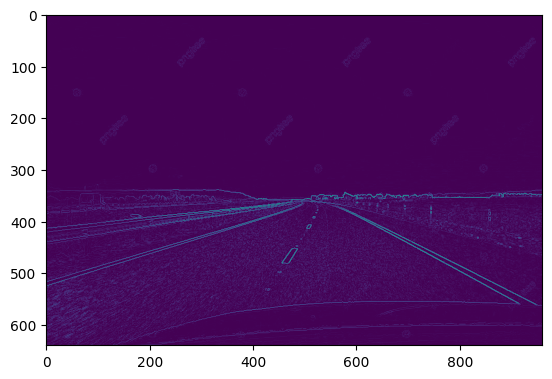

In [10]:
img_non_max = non_max_suppression_optimized(new_img,theta)
# print(img_non_max.max())
plt.imshow(img_non_max)
plt.show

Phân loại các pixel theo ngưỡng (mạnh, yếu, ngoại lệ)

Bước này nhằm mục đích xác định 3 loại pixel: mạnh, yếu và ngoại lai:

-Pixel mạnh là pixel có cường độ cao và trực tiếp góp phần vào sự hình thành cạnh.

-Pixel yếu là pixel có giá trị cường độ không đủ để được coi là mạnh nhưng chưa đủ nhỏ để được coi là ngoại lai.

-Các pixel khác được coi là ngoại lai.


In [11]:
def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.25):
    
    highThreshold = img.max() * highThresholdRatio;
    lowThreshold = highThreshold * lowThresholdRatio;
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res, weak, strong)

Theo dõi cạnh theo độ trễ 

Dựa trên kết quả sau khi áp dụng ngưỡng, Hysteresis Tracking chuyển đổi các pixel yếu thành mạnh, khi và chỉ khi ít nhất một trong các pixel xung quanh pixel đang xét là pixel mạnh, các pixel yếu còn lại bị loại bỏ, như được mô tả bên dưới:

![alt text](../dotre.png)

In [12]:
def hysteresis(img, weak, strong=255):
    M, N = img.shape  
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img

Model(Mô hình)

In [13]:
class EdgeDetector:
    def __init__(self, imgs, sigma=1, kernel_size=1, weak_pixel=1, strong_pixel=1, lowthreshold=1, highthreshold=1):
        self.imgs = imgs
        self.imgs_final = []
        self.img_smoothed = None
        self.gradientMat = None
        self.thetaMat = None
        self.nonMaxImg = None
        self.thresholdImg = None
        self.weak_pixel = weak_pixel
        self.strong_pixel = strong_pixel
        self.sigma = sigma
        self.kernel_size = kernel_size
        self.lowThreshold = lowthreshold
        self.highThreshold = highthreshold
    
    def gaussian_kernel(self, size, sigma=1):
        size = int(size) // 2
        x, y = np.mgrid[-size:size+1, -size:size+1]
        normal = 1 / (2.0 * np.pi * sigma**2)
        g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
        return g
    
    def sobel_filters(self,img):
        Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
        Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
        Ix = ndimage.convolve(img, Kx)
        Iy = ndimage.convolve(img, Ky)
        G = np.hypot(Ix, Iy)
        G = G / G.max() * 255
        theta = np.arctan2(Iy, Ix)
        return (G, theta)

    def non_max_suppression_optimized(self,img, D):
        M, N = img.shape
        Z = np.zeros((M,N), dtype=np.int32)
        angle = D * 180. / np.pi
        angle[angle < 0] += 180

        # Tinh chỉnh giá trị của các ngưỡng hướng
        angle_mask_right = (angle <= 22.5) | (angle > 157.5)
        angle_mask_top_right = (angle > 22.5) & (angle <= 67.5)
        angle_mask_top = (angle > 67.5) & (angle <= 112.5)
        angle_mask_top_left = (angle > 112.5) & (angle <= 157.5)

        # So sánh với các hàng xóm theo hướng cụ thể và áp dụng tinh chỉnh ngưỡng
        left_right = (img > np.roll(img, 1, axis=1)) & (img > np.roll(img, -1, axis=1))
        top_bottom = (img > np.roll(img, 1, axis=0)) & (img > np.roll(img, -1, axis=0))
        diag1 = (img > np.roll(np.roll(img, -1, axis=0), 1, axis=1)) & (img > np.roll(np.roll(img, 1, axis=0), -1, axis=1))
        diag2 = (img > np.roll(np.roll(img, 1, axis=0), 1, axis=1)) & (img > np.roll(np.roll(img, -1, axis=0), -1, axis=1))

        # Kết hợp các điều kiện để xác định cạnh
        Z[(angle_mask_right & left_right) | 
        (angle_mask_top & top_bottom) | 
        (angle_mask_top_right & diag1) | 
        (angle_mask_top_left & diag2)] = img[(angle_mask_right & left_right) | 
                                                (angle_mask_top & top_bottom) | 
                                                (angle_mask_top_right & diag1) | 
                                                (angle_mask_top_left & diag2)]
        return Z

    def non_max_suppression(self,img, D):
        M, N = img.shape
        Z = np.zeros((M,N), dtype=np.int32)
        angle = D * 180. / np.pi
        angle[angle < 0] += 180
        for i in range(1,M-1):
            for j in range(1,N-1):
                try:
                    q = 255
                    r = 255
                    if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                        q = img[i, j+1] # Pixel bên phải
                        r = img[i, j-1] # Pixel bên trái
                    elif (22.5 <= angle[i,j] < 67.5):
                        q = img[i-1, j+1] # Pixel trên phải
                        r = img[i+1, j-1] # Pixel dưới trái
                    elif (67.5 <= angle[i,j] < 112.5):
                        q = img[i-1, j] # Pixel trên
                        r = img[i+1, j] # Pixel dưới
                    elif (112.5 <= angle[i,j] < 157.5):
                        q = img[i-1, j-1] # Pixel trên trái
                        r = img[i+1, j+1] # Pixel dưới phải
                    if (img[i,j] >= q) and (img[i,j] >= r): 
                        Z[i,j] = img[i,j]
                    else:
                        Z[i,j] = 0
                except IndexError as e:
                    pass 
        return Z

    def threshold(self, img):
        highThreshold = img.max() * self.highThreshold;
        lowThreshold = highThreshold * self.lowThreshold;
        M, N = img.shape
        res = np.zeros((M,N), dtype=np.int32)
        weak = np.int32(self.weak_pixel)
        strong = np.int32(self.strong_pixel)
        strong_i, strong_j = np.where(img >= highThreshold)
        weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
        res[strong_i, strong_j] = strong
        res[weak_i, weak_j] = weak
        return (res)
    
    def hysteresis_optimize(self,img, low_threshold, high_threshold):
        M, N = img.shape
        strong_edges = (img > high_threshold)
        weak_edges = ((img >= low_threshold) & (img <= high_threshold))

        Z = np.zeros((M,N), dtype=np.int32)
        Z[strong_edges] = img[strong_edges]

        while np.any(weak_edges):
            # Find the weak edges next to strong edges
            new_strong_edges = (weak_edges & (np.roll(strong_edges, 1, axis=0) | 
                                            np.roll(strong_edges, -1, axis=0) | 
                                            np.roll(strong_edges, 1, axis=1) | 
                                            np.roll(strong_edges, -1, axis=1) |
                                            np.roll(np.roll(strong_edges, 1, axis=0), 1, axis=1) |
                                            np.roll(np.roll(strong_edges, 1, axis=0), -1, axis=1) |
                                            np.roll(np.roll(strong_edges, -1, axis=0), 1, axis=1) |
                                            np.roll(np.roll(strong_edges, -1, axis=0), -1, axis=1)))
            strong_edges[new_strong_edges] = True
            Z[new_strong_edges] = img[new_strong_edges]
            weak_edges[new_strong_edges] = False
        return Z

    def hysteresis(self, img):
        M, N = img.shape
        weak = self.weak_pixel
        strong = self.strong_pixel

        for i in range(1, M-1):
            for j in range(1, N-1):
                if (img[i,j] == weak):
                    try:
                        if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                            or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                            or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                            img[i, j] = strong
                        else:
                            img[i, j] = 0
                    except IndexError as e:
                        pass
        return img
    
    def detect(self):
        self.imgs_final = []
        for img in self.imgs:
            img_array = np.array(img)         
            self.img_smoothed = gaussian_filter(img_array, sigma=self.sigma)     
            self.gradientMat, self.thetaMat = self.sobel_filters(self.img_smoothed)
            self.nonMaxImg = self.non_max_suppression_optimized(self.gradientMat, self.thetaMat)           
            self.thresholdImg = self.threshold(self.nonMaxImg)
            # img_final = self.hysteresis(self.thresholdImg)
            img_final = self.hysteresis_optimize(self.thresholdImg,self.lowThreshold,self.highThreshold)
            self.imgs_final.append(img_final)
        return self.imgs_final

In [14]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.15989 * r + 0.9870 * g + 0.00140 * b
    return gray

In [15]:
imgs = mpimg.imread(r"D:\\project_CTV\\road2.jpg")
imgs = imgs.mean(axis=2)
print(imgs.shape)
# plt.imshow(imgs)
# plt.show()

(640, 960)


sigma: Sigma được sử dụng trong quá trình làm mờ Gaussian để kiểm soát mức độ làm mờ. Giá trị sigma cao hơn dẫn đến việc làm mờ nhiều hơn, giúp giảm nhiễu trong ảnh trước khi thực hiện phát hiện cạnh. Lựa chọn sigma ảnh hưởng đến độ nhạy của việc phát hiện cạnh đối với các chi tiết nhỏ so với các cạnh rộng lớn.

kernel_size: Tham số này chỉ định kích thước của kernel được sử dụng cho làm mờ Gaussian và bộ lọc Sobel. Kích thước kernel lớn hơn có thể dẫn đến việc làm mờ hoặc làm mịn nhiều hơn, ảnh hưởng đến việc phát hiện cạnh mảnh so với cạnh rộng. Kích thước kernel phải là số lẻ và thường nằm trong khoảng từ 3 đến 7 hoặc nhiều hơn, tùy thuộc vào mức độ chi tiết mong muốn.

weak_pixel: Trong quá trình ngưỡng, giá trị này đại diện cho cường độ được gán cho các cạnh yếu. Các cạnh yếu là những cạnh không nổi bật nhưng có thể vẫn là một phần của cạnh. Lựa chọn giá trị này có thể ảnh hưởng đến khả năng của thuật toán trong việc bảo tồn hoặc loại bỏ các cạnh yếu trong bước hysteresis.

strong_pixel: Giá trị này đại diện cho cường độ được gán cho các cạnh mạnh, có khả năng cao là cạnh thực sự trong ảnh. Đặt giá trị cao hơn giúp phân biệt rõ ràng cạnh mạnh với cạnh yếu và không phải cạnh.

lowthreshold: Tham số này định nghĩa ngưỡng dưới cho bước ngưỡng. Đây là một phần của cường độ tối đa trong ảnh gradient và giúp xác định các cạnh yếu. Giảm ngưỡng này có thể dẫn đến việc phát hiện nhiều cạnh hơn, bao gồm cả nhiễu, trong khi tăng nó có thể bỏ sót các chi tiết mảnh.

highthreshold: Tương tự như lowthreshold, nhưng nó thiết lập ngưỡng trên cho việc ngưỡng. Các cạnh có cường độ cao hơn ngưỡng này được coi là cạnh mạnh. Tham số này quan trọng trong việc xác định những cạnh nào đủ nổi bật để được giữ lại trong kết quả phát hiện cạnh cuối cùng.

In [16]:
detector = EdgeDetector([imgs], sigma=1.5, kernel_size=3, lowthreshold=0.07, highthreshold=0.30, weak_pixel=10,strong_pixel=2000)
imgs_final = detector.detect()


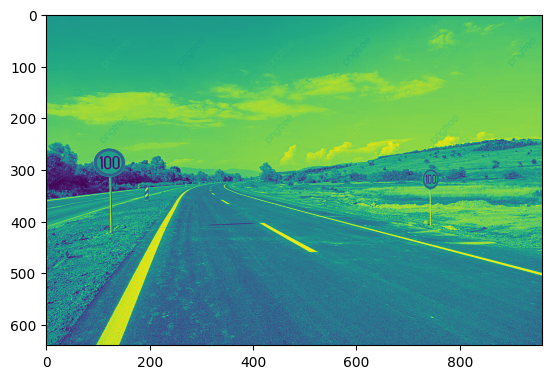

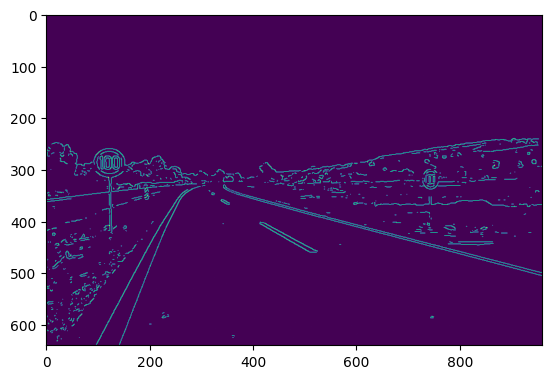

In [17]:
plt.imshow(imgs)
plt.show()
plt.imshow(imgs_final[0])
plt.show()

Dưới đây mình sử dụng thuần thư viện CV2

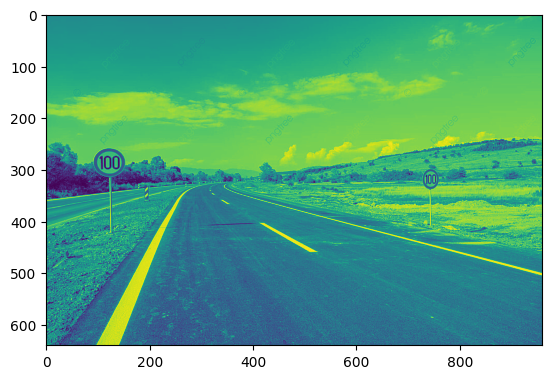

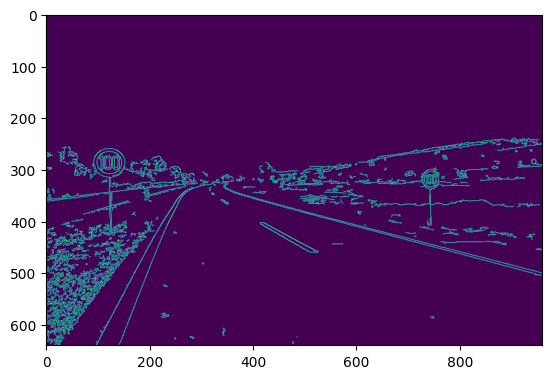

In [18]:
image = cv2.imread('D:\\project_CTV\\road2.jpg', cv2.IMREAD_GRAYSCALE)
if image is None:
    print('Không thể đọc được ảnh!')
    exit()
canny = cv2.Canny(image,threshold1=500,threshold2=200,L2gradient=True,apertureSize=3,)
plt.imshow(image)
plt.show()
plt.imshow(canny)
plt.show()


Phần này mình sẽ làm thêm phần road line detection để chuẩn bị cho cuộc đua số 2024 :D

In [19]:
import cv2

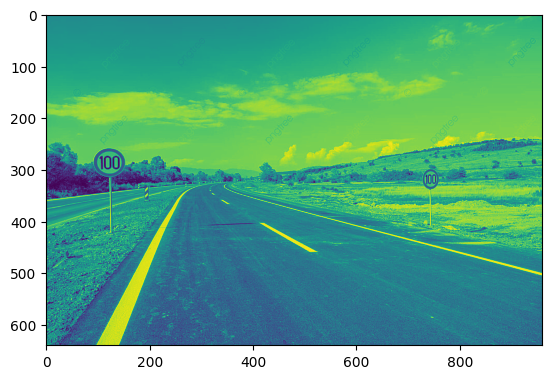

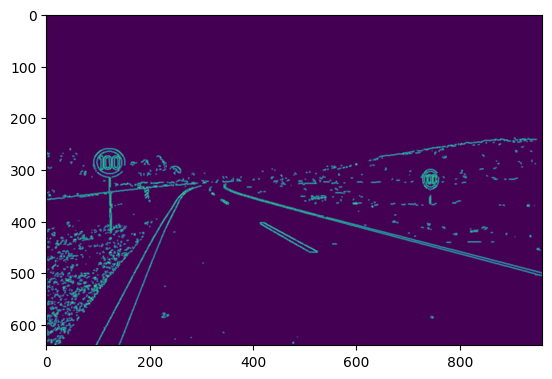

In [20]:
image = cv2.imread('D:\\project_CTV\\road2.jpg', cv2.IMREAD_GRAYSCALE)
# Make gray image
# image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
def detect_lines(image):
    # Apply Gaussian blur
    blurred_image = cv2.GaussianBlur(image, (3, 3), 0)
    return blurred_image
canny = cv2.Canny(image,threshold1=500,threshold2=400,L2gradient=True,apertureSize=3,)
detected_image = detect_lines(canny)

plt.imshow(image)
plt.show()
plt.imshow(detected_image)
plt.show()

Not enough lines found
positiveSlopes:  []
negativeSlopes:  [-0.50666667 -0.53146853 -0.55136986 -0.5754717  -0.44554455 -0.51666667
 -0.49242424 -0.53061224]
Invalid positive slope: Skipping positive slope line.
Invalid positive slope: Skipping positive slope line.


c:\Users\ADMIN\anaconda3\envs\myenv\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ADMIN\anaconda3\envs\myenv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\ADMIN\anaconda3\envs\myenv\lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\ADMIN\anaconda3\envs\myenv\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\ADMIN\anaconda3\envs\myenv\lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 1.0, 'Final Output')

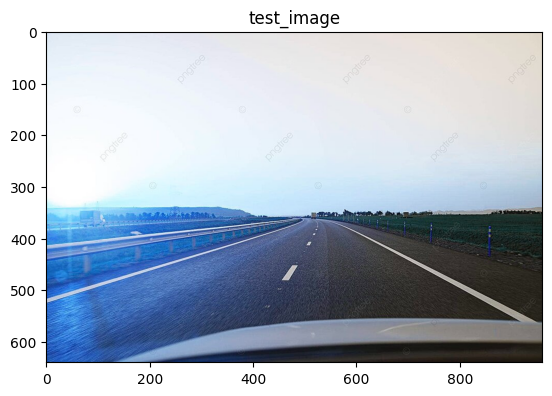

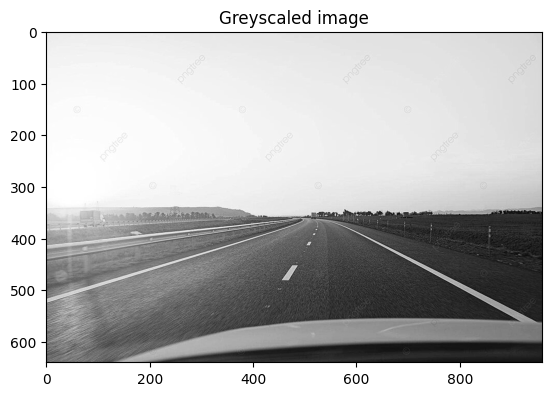

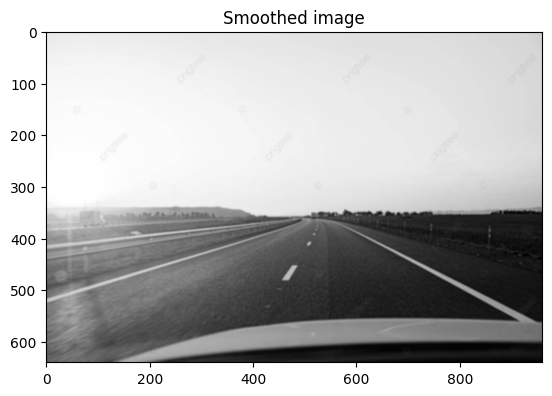

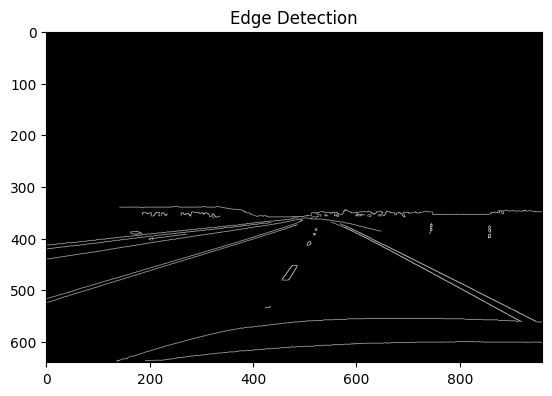

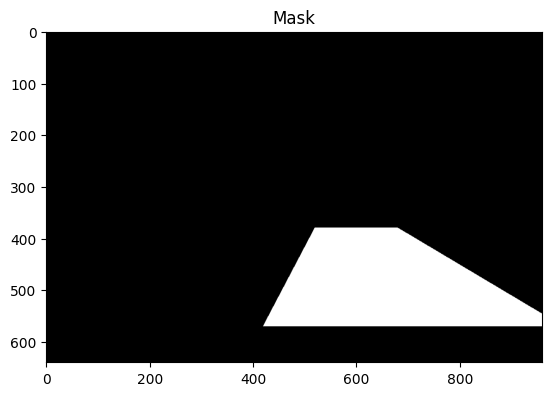

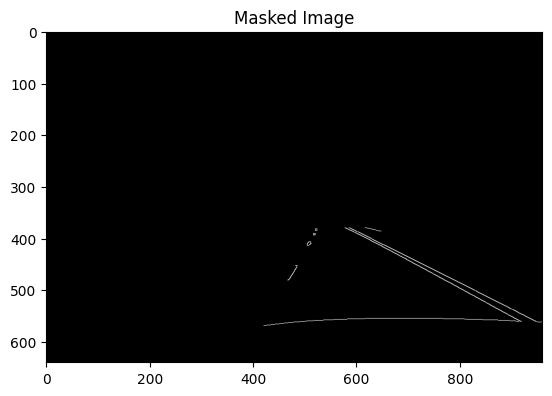

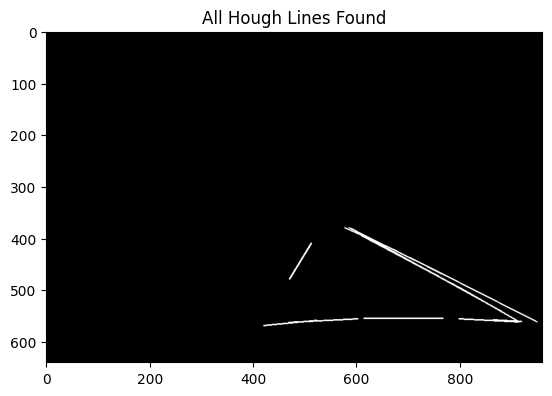

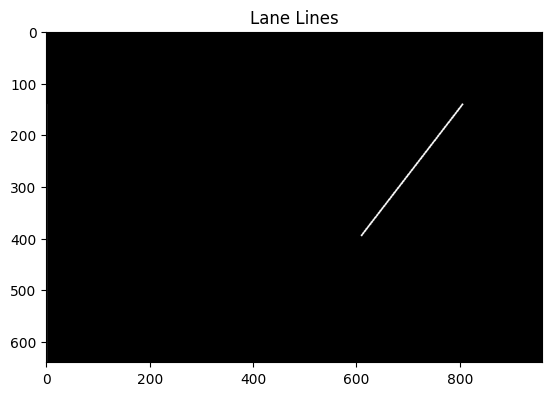

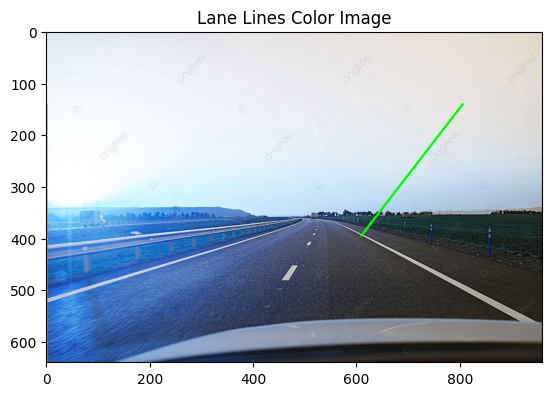

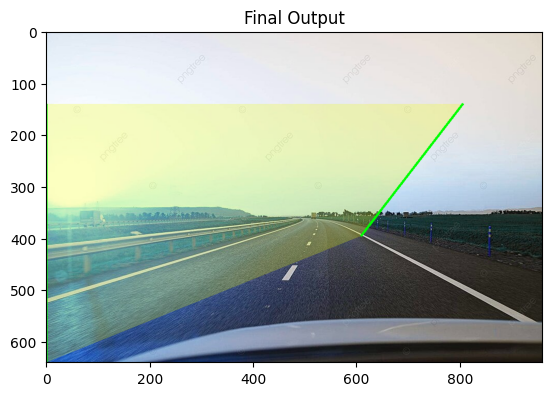

In [21]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os

# test_images = [mpimg.imread('test_video/videoFrames/' + i) for i in os.listdir('test_video/videoFrames/')]
# test_image_names = ['test_video/videoFrames/'+i for i in os.listdir('test_video/videoFrames/')]
test_image = cv2.imread('D:\\project_CTV\\road1.jpg')
im = test_image
imshape = im.shape
plt.figure(1)
plt.imshow(im)
plt.title('test_image')

grayIm = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
plt.figure(2)
plt.imshow(grayIm,cmap='gray')
plt.title('Greyscaled image')


#------------GAUSSIAN SMOOTHING-----------------
# Use low pass filter to remove noise. Will remove high freq stuff like noise and edges
# kernel_size specifies width/height of kernel, should be positive and odd
# Also specify stand dev in X and Y direction, give zero to calculate from kernel size
# Can also use average, median, and bilarteral blurring techniques
kernel_size = 7 # bigger kernel = more smoothing
smoothedIm = cv2.GaussianBlur(grayIm, (kernel_size, kernel_size), 0)
plt.figure(3)
plt.imshow(smoothedIm,cmap='gray')
plt.title('Smoothed image')


#-------------EDGE DETECTION---------------------
# finds gradient in x,y direction, gradient direction is perpendicular to edges
# checks pixels in gradient directions to see if they are local maximums, meaning on an edge
# hysteresis thresholding has min and max value, edges with gradient intensity big enough are edges
# edges that lie in bewteen are check to see if they connect to edges with intensity greater than max value, then it is considered edge
# also assumes edges are long lines (not small pixels regions)
minVal = 60
maxVal = 150
edgesIm = cv2.Canny(smoothedIm, minVal, maxVal)
plt.figure(4)
implot = plt.imshow(edgesIm,cmap='gray')

#plt.scatter([0],[imshape[0]])
#plt.scatter([465],[320])
#plt.scatter([475],[320])
#plt.scatter([imshape[1]],[imshape[0]])

plt.title('Edge Detection')


#-------------------------CREATE MASK--------------------------------
# Create mask to only keep area defined by four coners
# Black out every area outside area
vertices = np.array([[(420,570),(520,380), (680, 380), (1000,570)]], dtype=np.int32)
# defining a blank mask to start with, 0s with same shape of edgesIm
mask = np.zeros_like(edgesIm)     
# fill pixels inside the polygon defined by vertices"with the fill color  
color = 255
cv2.fillPoly(mask, vertices, color)

# show mask
plt.figure(5)
plt.imshow(mask,cmap='gray')
plt.title('Mask')
    
#----------------------APPLY MASK TO IMAGE-------------------------------
# create image only where mask and edge Detection image are the same
maskedIm = cv2.bitwise_and(edgesIm, mask)
# Plot output of mask
plt.figure(6)
plt.imshow(maskedIm,cmap='gray')
plt.title('Masked Image')

# Plot masked edges image
maskedIm3Channel = cv2.cvtColor(maskedIm, cv2.COLOR_GRAY2BGR)
#-----------------------HOUGH LINES------------------------------------
rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 45     # minimum number of votes (intersections in Hough grid cell)
min_line_len = 40 #minimum number of pixels making up a line
max_line_gap = 100    # maximum gap in pixels between connectable line segments
lines = cv2.HoughLinesP(maskedIm, rho, theta, threshold, np.array([]), 
                            minLineLength=min_line_len, maxLineGap=max_line_gap)
# Check if we got more than 1 line
if lines is not None and len(lines) > 2:
    # Draw all lines onto image
    allLines = np.zeros_like(maskedIm)
    for i in range(len(lines)):
        for x1,y1,x2,y2 in lines[i]:
            cv2.line(allLines,(x1,y1),(x2,y2),(255,255,0),2) # plot line
    # Plot all lines found
    plt.figure(7)
    plt.imshow(allLines,cmap='gray')
    plt.title('All Hough Lines Found')
    #-----------------------Separate Lines Intro Positive/Negative Slope--------------------------
    # Separate line segments by their slope to decide left line vs. the right line
    slopePositiveLines = [] # x1 y1 là tọa độ điểm bắt đầu, x2 y2 là tọa độ điểm kết thúc, slope là độ dốc 
    slopeNegativeLines = []
    yValues = []   
    # Loop through all lines
    addedPos = False
    addedNeg = False
    for currentLine in lines:   
        # Get points of current Line
        for x1,y1,x2,y2 in currentLine:
            lineLength = ((x2-x1)**2 + (y2-y1)**2)**0.5 # tính toán độ dài đoạn thẳng(line đường)
            if lineLength > 30: # Nếu đoạn thẳng đủ dài 
                if x2 != x1: # x1 không trùng x2
                    slope = (y2-y1)/(x2-x1) #  tính toán độ dốc của đoạn thẳng.
                    if slope > 0: #Nếu độ dốc dương
                        # và góc nghiêng của đoạn thẳng nằm trong khoảng giới hạn (20 đến 85 độ)
                        tanTheta = np.tan((abs(y2-y1))/(abs(x2-x1))) # tan(theta) value
                        ang = np.arctan(tanTheta)*180/np.pi
                        if abs(ang) < 85 and abs(ang) > 20:
                            slopeNegativeLines.append([x1,y1,x2,y2,-slope]) # add positive slope line
                            yValues.append(y1)
                            yValues.append(y2)
                            addedPos = True # thì đoạn thẳng được thêm vào danh sách đường lái dương.
                    if slope < 0:
                        # nếu độ dốc âm và góc nghiêng của đoạn thẳng nằm trong khoảng giới hạn (20 đến 85 độ)
                        tanTheta = np.tan((abs(y2-y1))/(abs(x2-x1))) # tan(theta) value
                        ang = np.arctan(tanTheta)*180/np.pi  # tính toán góc nghiêng
                        if abs(ang) < 85 and abs(ang) > 20:
                            slopePositiveLines.append([x1,y1,x2,y2,-slope]) # đoạn thẳng được thêm vào danh sách đường lái âm.
                            yValues.append(y1)
                            yValues.append(y2)
                            addedNeg = True          
    # Nếu không có đoạn thẳng dương hoặc âm được thêm vào danh sách
    #=>>thử lại bằng cách duyệt qua tất cả các đoạn thẳng một lần nữa và thêm vào các đoạn thẳng có độ dốc phù hợp.       
    if not addedPos:
        for currentLine in lines:
            for x1,y1,x2,y2 in currentLine:
                slope = (y2-y1)/(x2-x1)
                if slope > 0:
                    # kiểm tra lại góc
                    tanTheta = np.tan((abs(y2-y1))/(abs(x2-x1))) # tan(theta) value
                    ang = np.arctan(tanTheta)*180/np.pi
                    if abs(ang) < 80 and abs(ang) > 15:
                        slopeNegativeLines.append([x1,y1,x2,y2,-slope])
                        yValues.append(y1)
                        yValues.append(y2) 
    if not addedNeg:
        for currentLine in lines:
            for x1,y1,x2,y2 in currentLine:
                slope = (y2-y1)/(x2-x1)
                if slope < 0:
                    # Check angle of line w/ xaxis. dont want vertical/horizontal lines
                    tanTheta = np.tan((abs(y2-y1))/(abs(x2-x1))) # tan(theta) value
                    ang = np.arctan(tanTheta)*180/np.pi
                    if abs(ang) < 85 and abs(ang) > 15:
                        slopePositiveLines.append([x1,y1,x2,y2,-slope])
                        print(slopePositiveLines)           
                        yValues.append(y1)
                        yValues.append(y2)   
    if not addedPos or not addedNeg:
        print('Not enough lines found')
        
    #------------------------Get Positive/Negative Slope Averages-----------------------------------
    # Average position of lines and extrapolate to the top and bottom of the lane.
    positiveSlopes = np.asarray(slopePositiveLines)
    print("positiveSlopes: ",positiveSlopes)
    posSlopeMedian = np.median(positiveSlopes) # tính trung vị của các đoạn thẳng dương
    posSlopeStdDev = np.std(positiveSlopes) # tính độ lệch chuẩn
    posSlopesGood = []
    #Sau đó, lặp qua tất cả các đoạn thẳng dương và lọc ra các đoạn thẳng có độ dốc gần với độ dốc trung vị (posSlopeMedian)
    #với một ngưỡng cho trước (trong trường hợp này, được tính dựa trên 20% của độ dốc trung vị).
    for slope in positiveSlopes:
       # if abs(slope-posSlopeMedian) < .9:
       if abs(slope-posSlopeMedian) < posSlopeMedian*.2:
            posSlopesGood.append(slope)
    #Tính toán độ dốc trung bình của các đoạn thẳng dương sau khi lọc và lưu vào posSlopeMean.
    posSlopeMean = np.mean(np.asarray(posSlopesGood))
            
    #Tương tự như đường lái dương, tính toán độ dốc trung bình (negSlopeMean) của tất cả các đoạn thẳng có hướng âm.
    negativeSlopes = np.asarray(slopeNegativeLines)[:,4]
    print("negativeSlopes: ",negativeSlopes)
    negSlopeMedian = np.median(negativeSlopes)
    negSlopeStdDev = np.std(negativeSlopes)
    negSlopesGood = []
    for slope in negativeSlopes:
        # if abs(slope-negSlopeMedian) < .9:
        if abs(slope-negSlopeMedian) > negSlopeMedian*.2:
            negSlopesGood.append(slope)
    negSlopeMean = np.mean(np.asarray(negSlopesGood))
        
    #--------------------------Get Average x Coord When y Coord Of Line = 0----------------------------
    # Positive Lines
    xInterceptPos = []
    for line in slopePositiveLines:
            x1 = line[0]
            y1 = im.shape[0]-line[1] # y axis is flipped
            slope = line[4]
            yIntercept = y1-slope*x1
            xIntercept = -yIntercept/slope # find x intercept based off y = mx+b
            if xIntercept == xIntercept: # checks for nan
                xInterceptPos.append(xIntercept) # add x intercept
            
    xIntPosMed = np.median(xInterceptPos) # get median 
    xIntPosGood = [] # if not near median we get rid of that x point
    for line in slopePositiveLines:
            x1 = line[0]
            y1 = im.shape[0]-line[1]
            slope = line[4]
            yIntercept = y1-slope*x1
            xIntercept = -yIntercept/slope
            if abs(xIntercept-xIntPosMed) < .35*xIntPosMed: # check if near median
                xIntPosGood.append(xIntercept)
                    
    xInterceptPosMean = np.mean(np.asarray(xIntPosGood)) # average of good x intercepts for positive line
    
    # Negative Lines 
    xInterceptNeg = []
    for line in slopeNegativeLines:
        x1 = line[0]
        y1 = im.shape[0]-line[1]
        slope = line[4]
        yIntercept = y1-slope*x1
        xIntercept = -yIntercept/slope
        if xIntercept == xIntercept: # check for nan
                xInterceptNeg.append(xIntercept)
                
    xIntNegMed = np.median(xInterceptNeg)
    xIntNegGood = []
    for line in slopeNegativeLines:
        x1 = line[0]
        y1 = im.shape[0]-line[1]
        slope = line[4]
        yIntercept = y1-slope*x1
        xIntercept = -yIntercept/slope
        if abs(xIntercept-xIntNegMed)< .35*xIntNegMed: 
                xIntNegGood.append(xIntercept)
                
    xInterceptNegMean = np.mean(np.asarray(xIntNegGood))
    
# ----------------------PLOT LANE LINES------------------------------
# Need end points of line to draw in. Have x1,y1 (xIntercept,im.shape[1]) where
# im.shape[1] is the bottom of the image. take y2 as some num (min/max y in the good lines?)
# then find corresponding x

# make new black image
laneLines = np.zeros_like(edgesIm)   
colorLines = im.copy()

# Positive Slope Line
if not np.isnan(posSlopeMean) and abs(posSlopeMean) > 1e-6:  # Avoid division by zero or NaN slopes
    slope = posSlopeMean
    x1 = xInterceptPosMean
    y1 = 0
    y2 = imshape[0] - (imshape[0]-imshape[0]*.35)
    x2 = (y2-y1)/slope + x1
else:
    print("Invalid positive slope: Skipping positive slope line.")
# Plot positive slope line
x1 = int(round(x1))
x2 = int(round(x2))
y1 = int(round(y1))
y2 = int(round(y2))
cv2.line(laneLines,(x1,im.shape[0]-y1),(x2,imshape[0]-y2),(255,255,0),2) # plot line
cv2.line(colorLines,(x1,im.shape[0]-y1),(x2,imshape[0]-y2),(0,255,0),4) # plot line on color image


# Negative Slope Line
if not np.isnan(posSlopeMean) and abs(posSlopeMean) >0: 
    slope = negSlopeMean
    x1N = xInterceptNegMean
    y1N = 0
# y2 = imshape[0] - (imshape[0]-imshape[0]*.35)
    x2N = (y2-y1N)/slope + x1N
else:
     print("Invalid positive slope: Skipping positive slope line.")

x1N = 0
x2N = 0
y1N = 0
# Plot negative Slope Line
x1N = int(round(x1N))
x2N = int(round(x2N))
y1N = int(round(y1N))
cv2.line(laneLines,(x1N,imshape[0]-y1N),(x2N,imshape[0]-y2),(255,255,0),2)
cv2.line(colorLines,(x1N,im.shape[0]-y1N),(x2N,imshape[0]-y2),(0,255,0),4) # plot line on color iamge

# Plot lane lines
plt.figure(8)
plt.imshow(laneLines,cmap='gray')
plt.title('Lane Lines')

# Plot lane lines on original image
plt.figure(9)
plt.imshow(colorLines)
plt.title('Lane Lines Color Image')


#-------------------------------------Blend Image-----------------------------------------
laneFill = im.copy()
vertices = np.array([[(x1,im.shape[0]-y1),(x2,im.shape[0]-y2),  (x2N,imshape[0]-y2),
                                      (x1N,imshape[0]-y1N)]], dtype=np.int32)
color = [241,255,1]
cv2.fillPoly(laneFill, vertices, color)
opacity = .25
blendedIm =cv2.addWeighted(laneFill,opacity,im,1-opacity,0,im)
cv2.line(blendedIm,(x1,im.shape[0]-y1),(x2,imshape[0]-y2),(0,255,0),4) # plot line on color image
cv2.line(blendedIm,(x1N,im.shape[0]-y1N),(x2N,imshape[0]-y2),(0,255,0),4) # plot line on color image
b,g,r = cv2.split(blendedIm) # get bgr channels
outputIm = cv2.merge((r,g,b)) # make rgb

# Plot final output
plt.figure(10)
plt.imshow(blendedIm)
plt.title('Final Output')

